In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# Install dependencies

In [4]:
!nvidia-smi

Sun Jul 16 11:22:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# !export CUDA_HOME=/usr/local/cuda-10.1
# !git clone https://github.com/NVIDIA/apex
# !pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

In [6]:
!pip install ipdb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.8 MB/s eta 0:00:00


In [7]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.9 MB/s eta 0:00:00


In [8]:
!pip install transformers
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 51.4 MB/s eta 0:00:00


In [9]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 11.2 MB/s eta 0:00:00


# GraphQl Model

---



In [11]:
%pwd
import os
os.chdir("/content")
%pwd

'/content'

In [48]:
import os
from pathlib import Path
import argparse
import glob
import json
import time
import logging
import random
import re
import ipdb as pdb
from tqdm import tqdm
from itertools import chain
from string import punctuation
from transformers import T5Model, T5Tokenizer
import nltk

nltk.download('punkt')

from nltk.tokenize import sent_tokenize
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

logger = logging.getLogger(__name__)


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


class LoggingCallback(pl.Callback):
    def on_validation_end(self, trainer, pl_module):
        logger.info("***** Validation results *****")
        if pl_module.is_logger():
            metrics = trainer.callback_metrics
            # Log results
            for key in sorted(metrics):
                if key not in ["log", "progress_bar"]:
                    logger.info("{} = {}\n".format(key, str(metrics[key])))

    def on_test_end(self, trainer, pl_module):
        logger.info("***** Test results *****")

        if pl_module.is_logger():
            metrics = trainer.callback_metrics

            # Log and save results to file
            output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
            with open(output_test_results_file, "w") as writer:
                for key in sorted(metrics):
                    if key not in ["log", "progress_bar"]:
                        logger.info("{} = {}\n".format(key, str(metrics[key])))
                        writer.write("{} = {}\n".format(key, str(metrics[key])))


class GraphQlDataset(Dataset):
    def __init__(self, tokenizer, data_dir, type_path, max_len=512):
        self.pos_file_path = os.path.join(data_dir, 'dataset_' + type_path + "_pos.json")
        self.neg_file_path = os.path.join(data_dir, 'dataset_' + type_path + "_neg.json")

        self.max_len = max_len
        self.tokenizer = tokenizer
        self.inputs = []
        self.targets = []

        self._build()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        source_ids = self.inputs[index]["input_ids"].squeeze()
        target_ids = self.targets[index]["input_ids"].squeeze()

        src_mask = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
        target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}

    def _build(self):
        self._build_examples_from_files(self.pos_file_path, 'consistent')
        self._build_examples_from_files(self.neg_file_path, 'inconsistent')

    def _build_examples_from_files(self, file_path, consistency):
        with open(file_path, 'r') as reader:
            dataset = json.load(reader)

        REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
        REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

        for data_entry in tqdm(dataset):
            content = data_entry["content"].strip()
            content = REPLACE_NO_SPACE.sub("", content)
            content = REPLACE_WITH_SPACE.sub("", content)

            name = data_entry["name"].strip()
            name = REPLACE_NO_SPACE.sub("", name)
            name = REPLACE_WITH_SPACE.sub("", name)

            line = content + ' </s>' + name + ' </s>'

            target = consistency + " </s>"

            # tokenize inputs
            tokenized_inputs = self.tokenizer.batch_encode_plus(
                [line], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
            )
            # tokenize targets
            tokenized_targets = self.tokenizer.batch_encode_plus(
                [target], max_length=2, pad_to_max_length=True, return_tensors="pt"
            )

            self.inputs.append(tokenized_inputs)
            self.targets.append(tokenized_targets)


def get_dataset(tokenizer, type_path, args):
    return GraphQlDataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path, max_len=args.max_seq_length)


class T5FineTuner(pl.LightningModule):
    def __init__(self, hparams):
        super(T5FineTuner, self).__init__()
        self.save_hyperparameters(hparams)
        self.training_step_outputs = []
        self.validation_step_outputs = []
        # pdb.set_trace()
        self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
        self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)

    def is_logger(self):
        return self.trainer.global_rank <= 0

    def forward(
            self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, labels=None
    ):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=labels,
        )

    def _step(self, batch):
        labels = batch["target_ids"]
        labels[labels[:, :] == self.tokenizer.pad_token_id] = -100
        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            labels=labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs[0]

        return loss

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)
        self.training_step_outputs.append(loss)
        return {"loss": loss}

    def on_train_epoch_end(self):
        epoch_average = torch.stack(self.training_step_outputs).mean()
        self.log("training_epoch_average", epoch_average)
        self.training_step_outputs.clear()  # free memory
        return {"avg_train_loss": epoch_average}

    def validation_step(self, batch, batch_idx):
        loss = self._step(batch)
        self.validation_step_outputs.append(loss)
        return {"val_loss": loss}

    def on_validation_epoch_end(self):
        epoch_average = torch.stack(self.validation_step_outputs).mean()
        self.log("val_loss", epoch_average)
        self.validation_step_outputs.clear()  # free memory
        return {"val_loss": epoch_average}

    def configure_optimizers(self):
        """Prepare optimizer and schedule (linear warmup and decay)"""

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        self.opt = optimizer
        return [optimizer]

    def get_tqdm_dict(self):
        tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

        return tqdm_dict

    def train_dataloader(self):
        print('loadingtrain data')
        train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparams)
        dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True,
                                num_workers=4)
        t_total = (
                (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
                // self.hparams.gradient_accumulation_steps
                * float(self.hparams.num_train_epochs)
        )
        scheduler = get_linear_schedule_with_warmup(
            self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
        )
        self.lr_scheduler = scheduler
        return dataloader

    def val_dataloader(self):
        print('loading val data')
        val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="val", args=self.hparams)
        return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)


if __name__ == '__main__':
    set_seed(42)

    args_dict = dict(
        data_dir="",  # path for data files
        output_dir="",  # path to save the checkpoints
        model_name_or_path='t5-base',
        tokenizer_name_or_path='t5-base',
        max_seq_length=512,
        learning_rate=3e-4,
        weight_decay=0.0,
        adam_epsilon=1e-8,
        warmup_steps=0,
        train_batch_size=8,
        eval_batch_size=8,
        num_train_epochs=2,
        gradient_accumulation_steps=16,
        n_gpu=1,
        early_stop_callback=False,
        fp_16=False,  # if you want to enable 16-bit training then install apex and set this to true
        opt_level='O1',
        max_grad_norm=1.0,  # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
        seed=42,
    )

    # Prepare tokenizer
    tokenizer = T5Tokenizer.from_pretrained('t5-base')

    ids_neg = tokenizer.encode('inconsistent </s>')
    ids_pos = tokenizer.encode('consistent </s>')
    len(ids_neg), len(ids_pos)

    # Prepare dataset
    dataset = GraphQlDataset(tokenizer, 'tune', 'val', max_len=512)
    len(dataset)

    data = dataset[28]
    print(tokenizer.decode(data['source_ids']))
    print(tokenizer.decode(data['target_ids']))

    # Continue with model
    args_dict.update({'data_dir': 'tune', 'output_dir': 't5_graphql_consistency', 'num_train_epochs': 2})
    args = argparse.Namespace(**args_dict)

    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath=args.output_dir, filename="checkpoint", monitor="val_loss", mode="min", save_top_k=5
    )

    train_params = dict(
        accumulate_grad_batches=args.gradient_accumulation_steps,
        accelerator='gpu',
        max_epochs=args.num_train_epochs,
        precision=16 if args.fp_16 else 32,
        gradient_clip_val=args.max_grad_norm,
        callbacks=[LoggingCallback(), checkpoint_callback],
    )

    model = T5FineTuner(args)
    # Temporary for more speed:
    train_params["precision"] = '16-mixed'

    trainer = pl.Trainer(**train_params)





[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
100%|██████████| 1189/1189 [00:00<00:00, 1245.11it/s]


<unk> ordersinput <unk> status $status currentPage $currentPagetype$type <unk> <unk> list<unk> id price discount amount trade<unk> id price status <unk> orderItem<unk> id imageUrl title price amount number <unk> code time qrCode user<unk> id imageUrl nickname balance point role phone <unk> store <unk> name <unk> <unk> pagination <unk> total current pageSize <unk> <unk> <unk></s> $status OrderStatus$currentPage Int$typeOrderType</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [49]:
trainer.fit(model)

## save the model this way so next time you can load it using T5ForConditionalGeneration.from_pretrained
model.model.save_pretrained('graphql_consistency_model_filtered')
model.model.save_pretrained('/content/drive/MyDrive/finetune/graphql_consistency_model_filtered')

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

loading val data



  0%|          | 0/1164 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.

100%|██████████| 1164/1164 [00:01<00:00, 1148.27it/s]

100%|██████████| 1189/1189 [00:01<00:00, 1136.42it/s]


loadingtrain data


100%|██████████| 9517/9517 [00:08<00:00, 1115.45it/s]


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


# Evaluation

In [14]:
model.model = T5ForConditionalGeneration.from_pretrained("/content/drive/MyDrive/finetune/graphql_consistency_model_filtered")

In [15]:
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics

In [54]:
dataset = GraphQlDataset(tokenizer, 'tune', 'val',  max_len=512)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

100%|██████████| 1189/1189 [00:00<00:00, 1192.89it/s]


In [55]:
it = iter(loader)
batch = next(it)
batch["source_ids"].shape
model.model.to('cuda')

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [59]:
input_ids = batch['source_ids'].cuda()
attention_mask = batch['source_mask'].cuda()

outs = model.model.generate(input_ids=input_ids,
                              attention_mask=attention_mask,
                              max_length=2,
                              return_dict_in_generate=True,
                              output_scores=True)

dec = [tokenizer.decode(ids) for ids in outs["sequences"]]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]
scores = outs['scores']

print(str(scores))

(tensor([[-18.3795, -12.0877, -15.8797,  ..., -40.8154, -40.7751, -40.9336],
        [-18.1064, -12.1585, -13.9761,  ..., -39.3431, -39.3031, -39.4352],
        [-17.3566, -11.2973, -13.6567,  ..., -40.0316, -39.9358, -40.0939],
        ...,
        [-19.1558, -13.1846, -15.6194,  ..., -43.0600, -43.0335, -43.1654],
        [-21.5813, -13.3113, -18.2552,  ..., -46.8603, -46.7780, -46.9408],
        [-19.2360, -12.2083, -16.6075,  ..., -42.8764, -42.9195, -43.0311]],
       device='cuda:0'),)


In [57]:
for i in range(32):
    lines = textwrap.wrap("GraphQl Entry:\n%s\n" % texts[i], width=100)
    print("\n".join(lines))
    print("\nActual consistency: %s" % targets[i])
    print("Predicted consistency: %s" % dec[i])
    print("=====================================================================\n")

GraphQl Entry: <unk> registerusername $username email $email password $password <unk> ok errors
<unk> path message <unk> <unk> <unk></s> Me</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa
d><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa
d><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa
d><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa
d><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa
d><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa
d><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa
d><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa
d><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

# Test Metrics

In [52]:
model.model.to('cuda')

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [64]:
dataset = GraphQlDataset(tokenizer, 'tune', 'test', 512)
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []
targets = []
scores = []
texts = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(),
                              attention_mask=batch['source_mask'].cuda(),
                              max_length=2,
                              return_dict_in_generate=True,
                              output_scores=True)

  dec = [tokenizer.decode(ids).replace("<pad>","") for ids in outs["sequences"]]
  target = [tokenizer.decode(ids).replace("</s>", "") for ids in batch["target_ids"]]
  text = [tokenizer.decode(ids) for ids in batch['source_ids']]
  score = outs['scores']

  outputs.extend(dec)
  targets.extend(target)
  texts.extend(text)
  scores.extend(score)

100%|██████████| 251/251 [07:12<00:00,  1.72s/it]


In [65]:
import pickle
with open("eval_simple_filtered.pickle", "wb") as f:
  pickle.dump({ "outputs": outputs, "targets": targets, "texts": texts, "scores": scores}, f)

In [69]:


cons_id = tokenizer.encode("consistent")
incons_id = tokenizer.encode("inconsistent")
print("Id consistent: " + str(cons_id)+ ". Id inconsistent: "+ str(incons_id))

for i in range(32):
    lines = textwrap.wrap("GraphQl Entry:\n%s\n" % texts[i], width=100)
    print("\n".join(lines))
    print("\nActual consistency: %s" % targets[i])
    print("Predicted consistency: %s" % outputs[i])

    #scores_tensor = torch.tensor(scores[i])
    #softmax_scores = torch.softmax(scores_tensor, dim=-1)
    #p_cons = softmax_scores[cons_id]
    #p_incons = softmax_scores[incons_id]
    #print("P cons: %s" % p_cons)
    #print("P incons: %s" % p_incons)
    print("=====================================================================\n")

Id consistent: [4700, 1]. Id inconsistent: [26608, 1]
GraphQl Entry: <unk> delete_Follow where <unk> follower_id <unk> _eq $userId <unk> following_id
<unk> _eq $followingId <unk> <unk> <unk> affected_rows <unk> <unk></s> $followingId String $userId S
tring</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><
pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><
pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><
pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><
pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><
pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><
pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><
pad><pad><pad><pad><pad><pad><pad><pad><pa

In [70]:
for i, out in enumerate(outputs):
  if out not in ["consistent", "inconsistent"]:
    print(i, 'detected invalid prediction ' + str(out))

In [71]:
metrics.accuracy_score(targets, outputs)
print(str(targets))

['consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'consistent', 'cons

In [72]:
print(metrics.classification_report(targets, outputs))

              precision    recall  f1-score   support

  consistent       0.97      0.99      0.98      3776
inconsistent       0.99      0.97      0.98      4243

    accuracy                           0.98      8019
   macro avg       0.98      0.98      0.98      8019
weighted avg       0.98      0.98      0.98      8019



In [28]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [73]:
cm = metrics.confusion_matrix(targets, outputs)
print(str(len(cm)))

2


<Axes: >

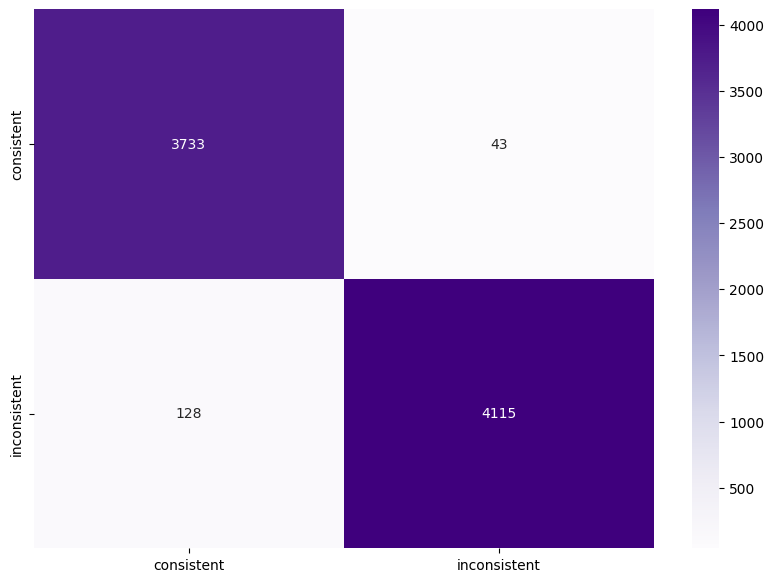

In [74]:
df_cm = pd.DataFrame(cm, index = ["consistent", "inconsistent"], columns = ["consistent", "inconsistent"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Purples', fmt='g')